In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import spams
from PIL import Image
from src.utils_dgmca import divisorGenerator
from src.utils_dgmca import Make_Experiment_GG
from src.utils_dgmca import mad
from src.misc_dgmca import *
from src.DGMCA import DGMCA as dgmca
from src.DGMCA_euclidean import DGMCA_euclidean
from src.GMCA import GMCA as gmca
import copy as cp
from tqdm import tqdm
import time

In [2]:
data_path = 'data/'
plots_path = 'plots/'

totalSize = 10000 #10000 # Number of samples for each observation/source

# For the batch sizes: Use all the divisors of totalSize bigger than minSizeBlock
# Or you can define the list manually by changing the array: divisors
minSizeBlock = 20
divisors = list(divisorGenerator(totalSize))
divisors = np.array(divisors)
divisors = divisors[divisors>=minSizeBlock]

# Define your own list of batch sizes
divisors = np.array([ 50, 100, 200,  500, 1000,  2000, 2500])
#divisors = np.array([  100,   125,   200,   250,   400,   500,   625,  1000,  1250, 2000, 2500])

lambdas = np.linspace(0.01,0.2,10)

n_lambda = len(lambdas)
n_s = 10 # Number of sources
n_obs = 20 # Number of observations
rho = 0.5 # Generalized Gaussian generation parameter
alpha_init = 2. # Alpha parameter for the thresholding strategy

numIts = 1 # Number of repetitions of the experiment

CA_ODL = np.zeros([2,len(divisors),n_lambda,numIts])
time_ODL = np.zeros([len(divisors),n_lambda,numIts])

# Recapitulative of the chosen parameters
print('*******************************************')
print('totalSize: ' + str(totalSize))
print('divisors: ' + str(divisors))
print('numIts: ' + str(numIts))
print('rho: ' + str(rho))
print('alpha_init: ' + str(alpha_init))
print('n_s: ' + str(n_s))
print('n_obs: ' + str(n_obs))
print('*******************************************')

# Define the saving name for the results
title_str = "test_basic_" + "_totalSize_" + str(totalSize) + "_numDivisors_" + str(len(divisors))+ "_n_obs_" + str(n_obs) \
    + "_n_s_" + str(n_s) + "_numIts_" + str(numIts)

print("Test saving name:")
print(title_str)
print('*******************************************')

*******************************************
totalSize: 10000
divisors: [  50  100  200  500 1000 2000 2500]
numIts: 1
rho: 0.5
alpha_init: 2.0
n_s: 10
n_obs: 20
*******************************************
Test saving name:
test_basic__totalSize_10000_numDivisors_7_n_obs_20_n_s_10_numIts_1
*******************************************


In [3]:
for it_n in tqdm(range(numIts)):

    X,X0,A0,S0,N = Make_Experiment_GG(n_s=n_s,n_obs=n_obs,t_samp=totalSize,noise_level=10.0,\
                                      dynamic=0,CondNumber=1,alpha=rho)
    
    X_ODL = np.asfortranarray(cp.deepcopy(X))


    for it1 in range(len(divisors)):
        numBlock = totalSize/divisors[it1]
        sizeBlock = divisors[it1]
        
        for it2 in range(len(lambdas)):
            lda = lambdas[it2]
            
            # ODL (Online Dictionary Learning)
            param = { 'K' : n_s, 'lambda1' : lda, 'numThreads' : 4, 'batchsize' : sizeBlock,
            'iter' : 1000, 'mode' : 0, 'modeD' : 0}
            time1 = time.time()
            A_ODL = spams.trainDL(X_ODL,**param)
            time_ODL[it1,it2,it_n] = time.time() - time1
            crit_ODL = EvalCriterion_eval(A0,S0,A_ODL,S0) 
            CA_ODL[0,it1,it2,it_n] = crit_ODL['ca_mean']
            CA_ODL[1,it1,it2,it_n] = crit_ODL['ca_med']     


100%|██████████| 1/1 [17:25<00:00, 1045.19s/it]


In [4]:
# Results
CA_ODL_mean = np.mean(CA_ODL,axis=3)
CA_ODL_med = np.median(CA_ODL,axis=3)

dB_CA_ODL_mean = -10*np.log10(CA_ODL_mean)
dB_CA_ODL_med = -10*np.log10(CA_ODL_med)


# Save variables
title_CA_ODL = data_path + 'CA_ODL' + title_str  
np.save(title_CA_ODL,CA_ODL)

# Import
ext = '.npy'
imp_CA_ODL = np.load(title_CA_ODL + ext)

# Mean over the experiments
imp_CA_ODL = np.mean(imp_CA_ODL,axis=3) # Over the iterations

# To dB
log_imp_CA_ODL = -10*np.log10(imp_CA_ODL)


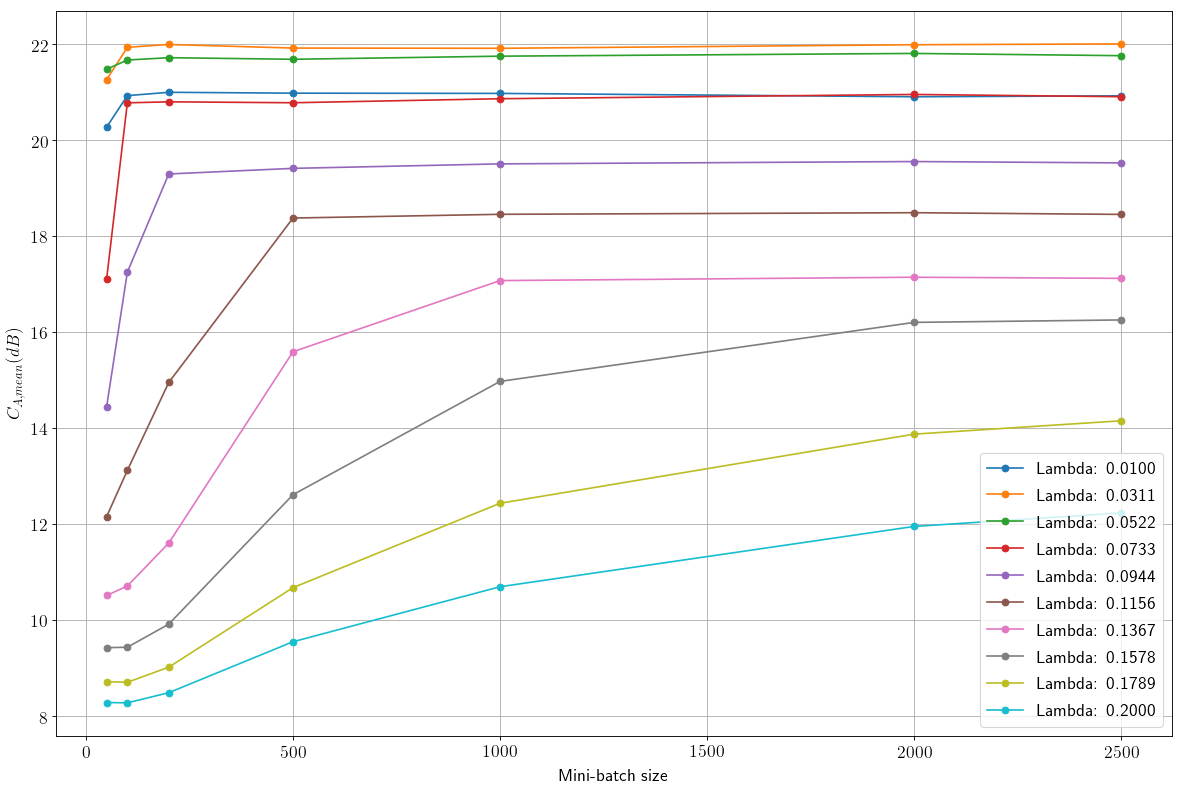

In [5]:
# Use the mean or the median over the CA 
type_ca = 0# 0 = CA_mean // 1 = CA_median

matplotlib.rcParams.update({'font.size': 16}) # 23
fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.rc('text', usetex=True)

for it in range(len(lambdas)):
    plt.plot(divisors[:], log_imp_CA_ODL[type_ca,:,it], '-o', label=r'Lambda: %.4f'%(lambdas[it]))

plt.xlabel('Mini-batch size')
if type_ca == 0:
    plt.ylabel(r'$C_{A,mean}(dB)$')
elif type_ca == 1:
    plt.ylabel(r'$C_{A,med}(dB)$')
plt.grid()
plt.legend()
plt.show()

title_str_pdf = plots_path + title_str + ".pdf"
fig.savefig(title_str_pdf, bbox_inches='tight')